# How to Build a Minimal Recommendation Engine

In this project, I explore the method to build a basic recommendation engine following a tutorial in the reference. And the dataset is from https://movielens.org/.
There're two types of recommedation methods: 
- content-based filtering: recommand based on the user's own rating history on one movie.
- collaborative filtering: recommand based on other user's rating history on one movie.

## 1. The MovieLens dataset: loading and first look

In [300]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [301]:
movies = pd.read_csv(r'ml-latest-small/movies.csv')
ratings = pd.read_csv(r'ml-latest-small/ratings.csv')
links = pd.read_csv(r'ml-latest-small/links.csv')
tags = pd.read_csv(r'ml-latest-small/tags.csv')
#genome_tags = pd.read_csv(r'ml-latest-small/genome-tags.csv')
#genome_scores = pd.read_csv(r'ml-latest-small/genome-scores.csv')

In [302]:
type(movies)

pandas.core.frame.DataFrame

In [303]:
print(movies.head(),movies.shape)

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy   (9125, 3)


In [304]:
print(ratings.head(),ratings.shape)

   userId  movieId  rating   timestamp
0       1       31     2.5  1260759144
1       1     1029     3.0  1260759179
2       1     1061     3.0  1260759182
3       1     1129     2.0  1260759185
4       1     1172     4.0  1260759205 (100004, 4)


In [305]:
print('How many users rated movies?',len(ratings['userId'].unique()))

How many users rated movies? 671


In [306]:
print('How many movies are rated?',len(ratings['movieId'].unique()))

How many movies are rated? 9066


In [307]:
print(links.head(),links.shape)

   movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0
3        4  114885  31357.0
4        5  113041  11862.0 (9125, 3)


In [308]:
print(tags.head(),tags.shape)

   userId  movieId                      tag   timestamp
0      15      339  sandra 'boring' bullock  1138537770
1      15     1955                  dentist  1193435061
2      15     7478                 Cambodia  1170560997
3      15    32892                  Russian  1170626366
4      15    34162              forgettable  1141391765 (1296, 4)


In [309]:
print('How many movies have tags?', len(tags['movieId'].unique()))

How many movies have tags? 689


## 2. Wrangling the movie dataset

In [310]:
movies_links = pd.merge(movies,links)
print(movies_links.head())
movies_links.shape

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  imdbId   tmdbId  
0  Adventure|Animation|Children|Comedy|Fantasy  114709    862.0  
1                   Adventure|Children|Fantasy  113497   8844.0  
2                               Comedy|Romance  113228  15602.0  
3                         Comedy|Drama|Romance  114885  31357.0  
4                                       Comedy  113041  11862.0  


(9125, 5)

In [356]:
movies_links_ratings = ratings.merge(movies_links,on='movieId',how='left')
#print(movies_links_ratings.sort_values(by=['movieId']).head())
#print(ratings[ratings.timestamp == 851866703])
#print(movies_links_ratings[movies_links_ratings.movieId == 850866703])
print(movies_links_ratings.head())

   userId  movieId  rating   timestamp  \
0       1       31     2.5  1260759144   
1       1     1029     3.0  1260759179   
2       1     1061     3.0  1260759182   
3       1     1129     2.0  1260759185   
4       1     1172     4.0  1260759205   

                                            title  \
0                          Dangerous Minds (1995)   
1                                    Dumbo (1941)   
2                                 Sleepers (1996)   
3                     Escape from New York (1981)   
4  Cinema Paradiso (Nuovo cinema Paradiso) (1989)   

                             genres  imdbId   tmdbId  
0                             Drama  112792   9909.0  
1  Animation|Children|Drama|Musical   33563  11360.0  
2                          Thriller  117665    819.0  
3  Action|Adventure|Sci-Fi|Thriller   82340   1103.0  
4                             Drama   95765  11216.0  


In [358]:
movielens_1 = movies_links_ratings.merge(tags,on=['userId','movieId'],how='left')
print(movielens_1.head())

   userId  movieId  rating  timestamp_x  \
0       1       31     2.5   1260759144   
1       1     1029     3.0   1260759179   
2       1     1061     3.0   1260759182   
3       1     1129     2.0   1260759185   
4       1     1172     4.0   1260759205   

                                            title  \
0                          Dangerous Minds (1995)   
1                                    Dumbo (1941)   
2                                 Sleepers (1996)   
3                     Escape from New York (1981)   
4  Cinema Paradiso (Nuovo cinema Paradiso) (1989)   

                             genres  imdbId   tmdbId  tag  timestamp_y  
0                             Drama  112792   9909.0  NaN          NaN  
1  Animation|Children|Drama|Musical   33563  11360.0  NaN          NaN  
2                          Thriller  117665    819.0  NaN          NaN  
3  Action|Adventure|Sci-Fi|Thriller   82340   1103.0  NaN          NaN  
4                             Drama   95765  11216.0  NaN

In [359]:
datetime.datetime.fromtimestamp(int('1260759144')).strftime("%Y-%m-%d %H:%M:%S")

'2009-12-13 21:52:24'

In [360]:
def get_datetime(timestamp_array):
    result = []
    for i in timestamp_array:
        if not np.isnan(i):
            result.append(datetime.datetime.fromtimestamp(int(i)).strftime("%Y-%m-%d %H:%M:%S"))
        else:
            result.append(np.NaN)
    return result

In [362]:
movielens_1['timestamp_ratings'] = get_datetime(movielens_1.timestamp_x)
movielens_1['timestamp_tags'] = get_datetime(movielens_1.timestamp_y)
movielens_2 = movielens_1.drop(['timestamp_x'],axis=1)
movielens = movielens_2.drop(['timestamp_y'],axis=1)
#movielens = movielens.dropna()

In [363]:
print(movielens.head())

   userId  movieId  rating                                           title  \
0       1       31     2.5                          Dangerous Minds (1995)   
1       1     1029     3.0                                    Dumbo (1941)   
2       1     1061     3.0                                 Sleepers (1996)   
3       1     1129     2.0                     Escape from New York (1981)   
4       1     1172     4.0  Cinema Paradiso (Nuovo cinema Paradiso) (1989)   

                             genres  imdbId   tmdbId  tag  \
0                             Drama  112792   9909.0  NaN   
1  Animation|Children|Drama|Musical   33563  11360.0  NaN   
2                          Thriller  117665    819.0  NaN   
3  Action|Adventure|Sci-Fi|Thriller   82340   1103.0  NaN   
4                             Drama   95765  11216.0  NaN   

     timestamp_ratings timestamp_tags  
0  2009-12-13 21:52:24            NaN  
1  2009-12-13 21:52:59            NaN  
2  2009-12-13 21:53:02            NaN  
3  2

In [364]:
def representInt(string):
    try:
        int(string)
        return True
    except ValueError:
        return False

In [365]:
def get_year_1(string): 
    m,n = 0,0
    for i in range(len(string)):
        if (string[i] == '(') & (i < len(string)-1):
            if representInt(string[i+1]):
                m = i
        if (string[i] == ')') & representInt(string[i-1]):
            n = i
    return string[m+1:n]

In [366]:
def get_year(array):
    result = []
    for i in array:
        result.append(get_year_1(i))
    return result

In [367]:
movielens['year'] = get_year(movielens['title'])
print(movielens.head())

   userId  movieId  rating                                           title  \
0       1       31     2.5                          Dangerous Minds (1995)   
1       1     1029     3.0                                    Dumbo (1941)   
2       1     1061     3.0                                 Sleepers (1996)   
3       1     1129     2.0                     Escape from New York (1981)   
4       1     1172     4.0  Cinema Paradiso (Nuovo cinema Paradiso) (1989)   

                             genres  imdbId   tmdbId  tag  \
0                             Drama  112792   9909.0  NaN   
1  Animation|Children|Drama|Musical   33563  11360.0  NaN   
2                          Thriller  117665    819.0  NaN   
3  Action|Adventure|Sci-Fi|Thriller   82340   1103.0  NaN   
4                             Drama   95765  11216.0  NaN   

     timestamp_ratings timestamp_tags  year  
0  2009-12-13 21:52:24            NaN  1995  
1  2009-12-13 21:52:59            NaN  1941  
2  2009-12-13 21:53:02    

In [378]:
def split_by(text):
    li = text.split('|')
    return li

In [435]:
genres_list = movies['genres'].apply(split_by)
#genres_series = genres_list.apply(pd.Series)
print(genres_list.head())

0    [Adventure, Animation, Children, Comedy, Fantasy]
1                       [Adventure, Children, Fantasy]
2                                    [Comedy, Romance]
3                             [Comedy, Drama, Romance]
4                                             [Comedy]
Name: genres, dtype: object


In [436]:
genres_total = set()
for l in genres_list:
    for e in l:
        if e != '(no genres listed)':
            genres_total.add(e)
print('Genres list:\n',genres_total)
print('\nHow many genres totally?\n',len(genres_total))

Genres list:
 {'Action', 'Thriller', 'Film-Noir', 'Western', 'War', 'Horror', 'Mystery', 'Documentary', 'Sci-Fi', 'IMAX', 'Adventure', 'Children', 'Musical', 'Comedy', 'Romance', 'Drama', 'Fantasy', 'Crime', 'Animation'}

How many genres totally?
 19


## 3. Apply the inferential statistics

In [368]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""

    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

### If mean of one user's rating is 3.5, does this user tend to overestimate or underestimate a movie?

3.6601501130101264


(array([  1.,   1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,
          0.,   1.,   0.,   2.,   1.,   5.,   3.,   7.,   6.,   7.,   9.,
         12.,  10.,  13.,  18.,  30.,  16.,  43.,  32.,  37.,  55.,  53.,
         36.,  39.,  38.,  43.,  30.,  28.,  26.,  22.,  18.,  10.,   7.,
          2.,   3.,   1.,   2.,   1.,   1.]),
 array([ 1.33333333,  1.40564103,  1.47794872,  1.55025641,  1.6225641 ,
         1.69487179,  1.76717949,  1.83948718,  1.91179487,  1.98410256,
         2.05641026,  2.12871795,  2.20102564,  2.27333333,  2.34564103,
         2.41794872,  2.49025641,  2.5625641 ,  2.63487179,  2.70717949,
         2.77948718,  2.85179487,  2.92410256,  2.99641026,  3.06871795,
         3.14102564,  3.21333333,  3.28564103,  3.35794872,  3.43025641,
         3.5025641 ,  3.57487179,  3.64717949,  3.71948718,  3.79179487,
         3.86410256,  3.93641026,  4.00871795,  4.08102564,  4.15333333,
         4.22564103,  4.29794872,  4.37025641,  4.4425641 ,  4.51487179,
 

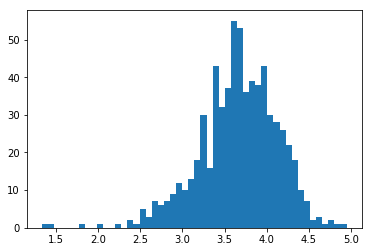

In [369]:
mean_rating_user = movielens.groupby('userId').mean()['rating']
print(mean_rating_user.mean())
plt.hist(mean_rating_user,bins=50)

3.6601501130101264
0.4699806522148716


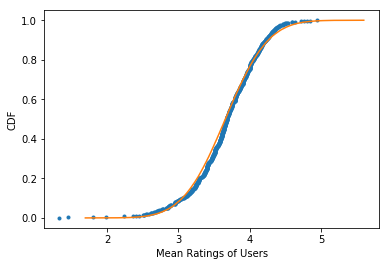

In [370]:
mean_user = np.mean(mean_rating_user)
std_user = np.std(mean_rating_user)
samples_user = np.random.normal(mean_user,std_user,100000)
x_theor_user, y_theor_user = ecdf(samples_user)
x_user, y_user = ecdf(mean_rating_user)
print(mean_user)
print(std_user)
_ = plt.plot(x_user, y_user, marker='.', linestyle='none')
_ = plt.plot(x_theor_user, y_theor_user)
_ = plt.xlabel('Mean Ratings of Users')
_ = plt.ylabel('CDF')

In this situation, it is appropriate to use the z statistic, because the value of mean is approximately a normal distribution.

In [371]:
def bootstrap_replicate_1d(data,func):
    bs_sample = np.random.choice(data,len(data))
    return func(bs_sample)
def draw_bs_reps(data,func,size=1):
    bs = np.empty(size)
    for i in range(size):
        bs[i] = bootstrap_replicate_1d(data,func)
    return bs

SEM is:  0.0181434018444
Standard deviation is:  0.0181552452631


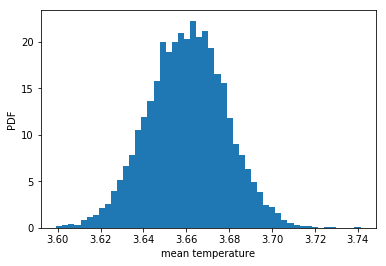

In [372]:
bs_replicates = draw_bs_reps(mean_rating_user,np.mean,size=10000)

# Compute and print SEM
sem = np.std(mean_rating_user) / np.sqrt(len(mean_rating_user))
print('SEM is: ', sem)

# Compute and print standard deviation of bootstrap replicates
bs_std = np.std(bs_replicates)
print('Standard deviation is: ', bs_std)

# Make a histogram of the results
_ = plt.hist(bs_replicates, bins=50, normed=True)
_ = plt.xlabel('mean temperature')
_ = plt.ylabel('PDF')

# Show the plot
plt.show()

In [373]:
z_score = (3.5 - np.mean(mean_rating_user))/sem
print('z score:', z_score)
from scipy import stats
p = (1-stats.norm.cdf(abs(z_score)))*2
print('p value:',p)

z score: -8.82690657374
p value: 0.0


According to the z score and p value above, if mean rating of a user is 3.5, he or she tends to underestimate a movie.

### If one movie's rating is 3.5, does this movie higher rated or lower rated?

(array([  9.40000000e+01,   0.00000000e+00,   9.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   1.82000000e+02,
          2.00000000e+00,   4.00000000e+00,   1.20000000e+01,
          8.00000000e+00,   1.00000000e+00,   1.73000000e+02,
          2.60000000e+01,   4.30000000e+01,   2.40000000e+01,
          1.30000000e+01,   3.84000000e+02,   1.80000000e+01,
          6.50000000e+01,   1.03000000e+02,   1.03000000e+02,
          4.80000000e+01,   4.73000000e+02,   6.80000000e+01,
          1.53000000e+02,   2.54000000e+02,   1.20000000e+02,
          8.97000000e+02,   1.34000000e+02,   2.36000000e+02,
          3.21000000e+02,   3.20000000e+02,   2.03000000e+02,
          8.71000000e+02,   2.83000000e+02,   3.13000000e+02,
          3.82000000e+02,   3.36000000e+02,   1.11600000e+03,
          1.15000000e+02,   1.76000000e+02,   1.90000000e+02,
          7.90000000e+01,   4.20000000e+01,   3.08000000e+02,
          6.00000000e+00,   1.50000000e+01,   2.50000000e+01,
        

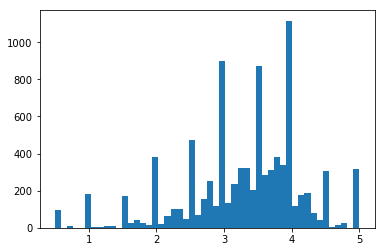

In [374]:
mean_rating_movies = movielens.groupby('movieId').mean()['rating']
plt.hist(mean_rating_movies,bins=50)

3.2930050962902686
0.8822316244502246


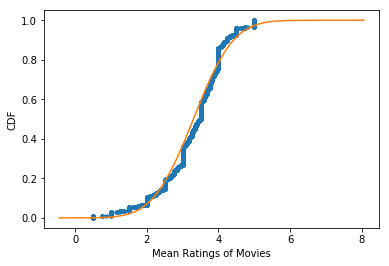

In [375]:
mean_movies = np.mean(mean_rating_movies)
std_movies = np.std(mean_rating_movies)
samples_movies = np.random.normal(mean_movies,std_movies,100000)
x_theor_movies, y_theor_movies = ecdf(samples_movies)
x_movies, y_movies = ecdf(mean_rating_movies)
print(mean_movies)
print(std_movies)
_ = plt.plot(x_movies, y_movies, marker='.', linestyle='none')
_ = plt.plot(x_theor_movies, y_theor_movies)
_ = plt.xlabel('Mean Ratings of Movies')
_ = plt.ylabel('CDF')

SEM is:  0.00926562595341
Standard deviation is:  0.00931088208933


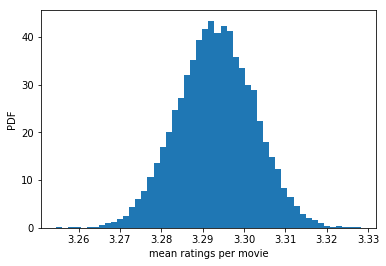

In [376]:
bs_replicates_movies = draw_bs_reps(mean_rating_movies,np.mean,size=10000)

# Compute and print SEM
sem_movies = np.std(mean_rating_movies) / np.sqrt(len(mean_rating_movies))
print('SEM is: ', sem_movies)

# Compute and print standard deviation of bootstrap replicates
bs_std_movies = np.std(bs_replicates_movies)
print('Standard deviation is: ', bs_std_movies)

# Make a histogram of the results
_ = plt.hist(bs_replicates_movies, bins=50, normed=True)
_ = plt.xlabel('mean ratings per movie')
_ = plt.ylabel('PDF')

# Show the plot
plt.show()

In [377]:
z_score_movies = (3.5 - np.mean(mean_rating_movies))/sem_movies
print('z score:', z_score_movies)
from scipy import stats
p_movies = (1-stats.norm.cdf(abs(z_score_movies)))*2
print('p value:',p_movies)

z score: 22.3400884895
p value: 0.0


According to the z score and p value, if a movie's rating is 3.5, it's significantly higher rated.

In [381]:
ratings_reshape = ratings[['userId','movieId','rating']].pivot(index='movieId',columns='userId',values='rating')
print(ratings_reshape.head())

userId   1    2    3    4    5    6    7    8    9    10  ...   662  663  664  \
movieId                                                   ...                   
1        NaN  NaN  NaN  NaN  NaN  NaN  3.0  NaN  4.0  NaN ...   NaN  4.0  3.5   
2        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   5.0  NaN  NaN   
3        NaN  NaN  NaN  NaN  4.0  NaN  NaN  NaN  NaN  NaN ...   NaN  NaN  NaN   
4        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   NaN  NaN  NaN   
5        NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN ...   NaN  NaN  NaN   

userId   665  666  667  668  669  670  671  
movieId                                     
1        NaN  NaN  NaN  NaN  NaN  4.0  5.0  
2        3.0  NaN  NaN  NaN  NaN  NaN  NaN  
3        3.0  NaN  NaN  NaN  NaN  NaN  NaN  
4        NaN  NaN  NaN  NaN  NaN  NaN  NaN  
5        3.0  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 671 columns]


## 4. Minimal reco engine and its evaluation

In [394]:
user_ids_larger_1 = pd.value_counts(movielens.userId, sort=False) > 1
user_ids_larger_1 = user_ids_larger_1[user_ids_larger_1].index

movielens = movielens.select(lambda l: movielens.loc[l, 'userId'] in user_ids_larger_1)
print(movielens.shape)
assert(np.all(movielens.userId.value_counts() > 1))

(100441, 11)


In [393]:
movielens.head()

,userId,movieId,rating,title,genres,imdbId,tmdbId,tag,timestamp_ratings,timestamp_tags,year
0,1,31,2.5,Dangerous Minds (1995),Drama,112792,9909.0,NaN,2009-12-13 21:52:24,NaN,1995
1,1,1029,3.0,Dumbo (1941),Animation|Children|Drama|Musical,33563,11360.0,NaN,2009-12-13 21:52:59,NaN,1941
2,1,1061,3.0,Sleepers (1996),Thriller,117665,819.0,NaN,2009-12-13 21:53:02,NaN,1996
3,1,1129,2.0,Escape from New York (1981),Action|Adventure|Sci-Fi|Thriller,82340,1103.0,NaN,2009-12-13 21:53:05,NaN,1981
4,1,1172,4.0,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama,95765,11216.0,NaN,2009-12-13 21:53:25,NaN,1989


### Split the dataset to train and test set

In [395]:
from sklearn.model_selection import train_test_split

In [400]:
movielens_train, movielens_test = train_test_split(movielens,test_size=0.2)
print(movielens.shape)
print(movielens_train.shape)
print(movielens_test.shape)

(100441, 11)
(80352, 11)
(20089, 11)


In [401]:
movielens_test.head()

,userId,movieId,rating,title,genres,imdbId,tmdbId,tag,timestamp_ratings,timestamp_tags,year
98413,654,6156,4.0,Shanghai Knights (2003),Action|Adventure|Comedy,300471,6038.0,NaN,2006-04-18 15:52:39,NaN,2003
42947,306,2171,4.0,Next Stop Wonderland (1998),Comedy|Drama|Romance,119778,41469.0,NaN,1999-10-12 05:01:50,NaN,1998
9172,60,2640,4.0,Superman (1978),Action|Adventure|Sci-Fi,78346,1924.0,NaN,2005-09-04 06:14:36,NaN,1978
83518,564,454,4.0,"Firm, The (1993)",Drama|Thriller,106918,37233.0,NaN,2000-11-20 05:22:07,NaN,1993
43567,311,368,3.0,Maverick (1994),Adventure|Comedy|Western,110478,9359.0,NaN,1998-06-16 10:43:37,NaN,1994


In [402]:
movielens_train.head()

,userId,movieId,rating,title,genres,imdbId,tmdbId,tag,timestamp_ratings,timestamp_tags,year
71772,501,1203,5.0,12 Angry Men (1957),Drama,50083,389.0,NaN,2011-06-30 20:24:04,NaN,1957
67162,468,54419,3.0,Czech Dream (Ceský sen) (2004),Documentary,402906,33916.0,NaN,2011-01-28 00:51:15,NaN,2004
49751,362,5669,4.5,Bowling for Columbine (2002),Documentary,310793,1430.0,NaN,2008-09-19 18:02:58,NaN,2002
13119,84,4993,4.5,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy,120737,120.0,NaN,2015-04-24 17:25:49,NaN,2001
36404,262,4816,2.5,Zoolander (2001),Comedy,196229,9398.0,NaN,2015-06-14 21:55:42,NaN,2001


In [343]:
movielens_train.to_csv('ml-latest-small/my_generated_movielens_train.csv')
movielens_test.to_csv('ml-latest-small/my_generated_movielens_test.csv')

### Evaluation: performance criterion
Some options for performance evaluation includes:
- RMSE: $\sqrt{\frac{\sum(\hat y - y)^2}{n}}$
- Precision / Recall / F-scores
- ROC curves
- Cost curves

And in this project RMSE is used as the performance criterion

In [344]:
def compute_rmse(y_pred, y_true):
    """ Compute Root Mean Squared Error. """
    
    return np.sqrt(np.mean(np.power(y_pred - y_true, 2)))

In [345]:
def evaluate(estimate_f):
    """ RMSE-based predictive performance evaluation with pandas. """
    
    ids_to_estimate = zip(movielens_test.userId, movielens_test.movieId)
    estimated = np.array([estimate_f(u,i) for (u,i) in ids_to_estimate])
    real = movielens_test.rating.values
    return compute_rmse(estimated, real)

In [346]:
def my_estimate_function(user_id, movie_id):
    return 3

In [347]:
print('RMSE for my estimate function: %s' % evaluate(my_estimate_function))

RMSE for my estimate function: 1.19270798792


In [403]:
movies_info = movies.set_index('movieId')
movies_info['year'] = get_year(movies['title'])
movies_info.head(5)

,title,genres,year
movieId,,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
2,Jumanji (1995),Adventure|Children|Fantasy,1995
3,Grumpier Old Men (1995),Comedy|Romance,1995
4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
5,Father of the Bride Part II (1995),Comedy,1995


### Content-based filtering using implicit sim functions

Using the similarity of genres among a series movies to estimate the unknow movie rating.

In [410]:
class ContentGenresReco:
    """ Collaborative filtering using an implicit sim(u,u'). """

    def learn(self):
        """ Prepare datastructures for estimation. """
        
        self.means_by_genres = movielens_train.pivot_table('rating', index='movieId', columns='genres')

    def estimate(self, userId, movieId):
        """ Mean ratings by other users of the same genres. """
        
        if movieId not in self.means_by_genres.index: 
            return 3.0
        
        movies_genres = movies_info.ix[movieId, 'genres']
        if ~np.isnan(self.means_by_genres.ix[movieId, movies_genres]):
            return self.means_by_genres.ix[movieId, movies_genres]
        else:
            return self.means_by_genres.ix[movieId].mean()

reco_genres = ContentGenresReco()
reco_genres.learn()
print('RMSE for CollabGenresReco: %s' % evaluate(reco_genres.estimate))

C:\Users\Alexander\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


RMSE for CollabGenresReco: 0.997038490192


Using the similarity of year of movies to estimate the unknow movie rating.

In [425]:
class ContentYearReco:
    """ Collaborative filtering using an implicit sim(u,u'). """

    def learn(self):
        """ Prepare datastructures for estimation. """
        
        self.means_by_year = movielens_train.pivot_table('rating', index='movieId', columns='year')

    def estimate(self, userId, movieId):
        """ Mean ratings by other users of the same year. """
        
        if movieId not in self.means_by_year.index: 
            return 3.0
        
        movies_year = movies_info.ix[movieId, 'year']
        if ~np.isnan(self.means_by_year.ix[movieId, movies_year]):
            return self.means_by_year.ix[movieId, movies_year]
        else:
            return self.means_by_year.ix[movieId].mean()

reco_year = ContentYearReco()
reco_year.learn()
print('RMSE for CollabYearReco: %s' % evaluate(reco_year.estimate))

C:\Users\Alexander\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


RMSE for CollabYearReco: 0.997038490192


### A few custom similarity functions

- Euclidean 'similarity'

$$ sim(x,y) = \frac{1}{1 + \sqrt{\sum (x - y)^2}}$$

In [422]:
def euclidean(s1, s2):
    """Take two pd.Series objects and return their euclidean 'similarity'."""
    diff = s1 - s2
    return 1 / (1 + np.sqrt(np.sum(diff ** 2)))

- Cosine similarity

$$ sim(x,y) = \frac{(x . y)}{\sqrt{(x . x) (y . y)}} $$

In [421]:
def cosine(s1, s2):
    """Take two pd.Series objects and return their cosine similarity."""
    return np.sum(s1 * s2) / np.sqrt(np.sum(s1 ** 2) * np.sum(s2 ** 2))

- Pearson correlation

$$ sim(x,y) = \frac{(x - \bar x).(y - \bar y)}{\sqrt{(x - \bar x).(x - \bar x) * (y - \bar y)(y - \bar y)}} $$

In [420]:
def pearson(s1, s2):
    """Take two pd.Series objects and return a pearson correlation."""
    s1_c = s1 - s1.mean()
    s2_c = s2 - s2.mean()
    return np.sum(s1_c * s2_c) / np.sqrt(np.sum(s1_c ** 2) * np.sum(s2_c ** 2))

- Jaccard similarity

$$ sim(x,y) = \frac{(x . y)}{(x . x) + (y . y) - (x . y)} $$

In [419]:
def jaccard(s1, s2):
    dotp = np.sum(s1 * s2)
    return dotp / (np.sum(s1 ** 2) + np.sum(s2 ** 2) - dotp)

def binjaccard(s1, s2):
    dotp = (s1.index & s2.index).size
    return dotp / (s1.sum() + s2.sum() - dotp)

### Collaborative-based filtering using custom sim functions

Incorporating the pearson r similarity of users 

In [424]:
class CollabPearsonReco:
    """ Collaborative filtering using a custom sim(u,u'). """

    def learn(self):
        """ Prepare datastructures for estimation. """
        
        self.all_user_profiles = movielens.pivot_table('rating', index='movieId', columns='userId')

    def estimate(self, userId, movieId):
        """ Ratings weighted by correlation similarity. """
        
        user_condition = movielens_train.userId != userId
        movie_condition = movielens_train.movieId == movieId
        ratings_by_others = movielens_train.loc[user_condition & movie_condition]
        if ratings_by_others.empty: 
            return 3.0
        
        ratings_by_others.set_index('userId', inplace=True)
        their_ids = ratings_by_others.index
        their_ratings = ratings_by_others.rating
        their_profiles = self.all_user_profiles[their_ids]
        user_profile = self.all_user_profiles[userId]
        sims = their_profiles.apply(lambda profile: pearson(profile, user_profile), axis=0)
        ratings_sims = pd.DataFrame({'sim': sims, 'rating': their_ratings})
        ratings_sims = ratings_sims[ratings_sims.sim > 0]
        if ratings_sims.empty:
            return their_ratings.mean()
        else:
            return np.average(ratings_sims.rating, weights=ratings_sims.sim)
        
reco_pearson = CollabPearsonReco()
reco_pearson.learn()
print('RMSE for CollabPearsonReco: %s' % evaluate(reco_pearson.estimate))

RMSE for CollabPearsonReco: 0.937770665459


Incorporating the cosine similarity of users 

In [426]:
class CollabPearsonReco:
    """ Collaborative filtering using a custom sim(u,u'). """

    def learn(self):
        """ Prepare datastructures for estimation. """
        
        self.all_user_profiles = movielens.pivot_table('rating', index='movieId', columns='userId')

    def estimate(self, userId, movieId):
        """ Ratings weighted by correlation similarity. """
        
        user_condition = movielens_train.userId != userId
        movie_condition = movielens_train.movieId == movieId
        ratings_by_others = movielens_train.loc[user_condition & movie_condition]
        if ratings_by_others.empty: 
            return 3.0
        
        ratings_by_others.set_index('userId', inplace=True)
        their_ids = ratings_by_others.index
        their_ratings = ratings_by_others.rating
        their_profiles = self.all_user_profiles[their_ids]
        user_profile = self.all_user_profiles[userId]
        sims = their_profiles.apply(lambda profile: cosine(profile, user_profile), axis=0)
        ratings_sims = pd.DataFrame({'sim': sims, 'rating': their_ratings})
        ratings_sims = ratings_sims[ratings_sims.sim > 0]
        if ratings_sims.empty:
            return their_ratings.mean()
        else:
            return np.average(ratings_sims.rating, weights=ratings_sims.sim)
        
reco = CollabPearsonReco()
reco.learn()
print('RMSE for CollabPearsonReco: %s' % evaluate(reco.estimate))

RMSE for CollabPearsonReco: 0.990199640509
